## This notebook shows the performance of a random forest model with different type of features

In [50]:
## importing the necessary dependencies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib

from obspy.geodetics.base import gps2dist_azimuth
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

In [51]:
## importing station and event metadata



iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])




stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278  ## coordinates of Columbia glacier. 

In [52]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events) ## To order the station-wise results according to total number of events recorded

### The following cell defines two functions. One functions is simple random forest function, other one is the random function but when each class has equal number of samples. This is just to test the sensitivity of specific set of features to the class imbalance. 

In [65]:
## We will define all the functions used in subsequent analysis in this cell. 


def forest_test(X, Y, n_estimators= 100):
    
    """
    This function applies Random Forest classification on the input X[n_samples, n_features] and corresponding
    labels y. It will split X into test and training according to ratio specified and output the accuracy,
    sensitivity and specificity. 
    n_estimators - number of decision trees
    Other parameters of random forests are same as in default model. 
    dur - refers to the time it took to train the model
    """
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.33, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    
    tn, fp, fn, tp = confusion_matrix(Y_Test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc, sensitivity, specificity, dur



## Forest test for balanced data.

def forest_test_balanced(X, Y, n_estimators= 100):
    
    """
    This function applies Random Forest classification on the input X[n_samples, n_features] and corresponding
    labels y. It will split X into test and training according to ratio specified and output the accuracy,
    sensitivity and specificity. 
    n_estimators - number of decision trees
    
    dur - refers to the time it took to train the model
    """
    
    n_iq = len(np.where(Y == 1)[0])
    n_eq = len(np.where(Y == 0)[0])
    
    print('No of Icequakes:'+str(n_iq))
    print('No of Earthquakes:'+str(n_eq))
    
    
    ## Balancing the samples in each class. 
    
    bal = min(n_iq, n_eq)
    iq_start = Y[np.where(Y==1)[0][0]:int(bal+np.where(Y == 1)[0][0])]
    eq_start = Y[np.where(Y==0)[0][0]:int(bal+np.where(Y == 0)[0][0])]
    
    iq_feature = X[np.where(Y == 1)[0][0]:int(bal+np.where(Y == 1)[0][0])]
    eq_feature = X[np.where(Y==0)[0][0]:int(bal+np.where(Y == 0)[0][0])]
    
    print('Icequakes:'+str(len(iq_start)))
    print('Earthquakes:'+str(len(eq_start)))
    
    
    Y = np.concatenate([iq_start, eq_start])
    X = np.concatenate([iq_feature, eq_feature])
    
    
    #print(Y)
    #print(X)
    
    #print(len(Y))
    #print(len(X))
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.20, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    

    
    
    
    
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    
    tn, fp, fn, tp = confusion_matrix(Y_Test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(Y_Test, predictionforest)
    
    #print(acc)
    #print(sensitivity)
    #print(specificity)
    #print(dur)
    
    return acc, sensitivity, specificity, dur





In [55]:
stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
stns

,#Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,AK,BAE,61.131900,-148.123400,578.0,"Barry Arm East, AK, USA",2020-09-04T00:00:00,2599-12-31T23:59:59
1,AK,BAT,61.141600,-148.175100,1027.0,"Barry Arm Top, AK, USA",2021-07-23T00:00:00,2599-12-31T23:59:59
2,AK,BAW,61.150100,-148.150100,542.0,"Barry Arm West, AK, USA",2020-09-04T00:00:00,2021-04-30T23:59:59
3,AK,EYAK,60.548698,-145.750000,133.9,"Cordova Ski Area, AK, USA",2002-10-03T00:00:00,2599-12-31T23:59:59
4,AK,FID,60.727699,-146.598694,500.0,"Fidalgo, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
5,AK,GLI,60.879200,-147.095901,430.0,"Glacier Island, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
6,AK,HIN,60.396000,-146.503494,622.9,"Hinchinbrook, AK, USA",2009-11-01T00:00:00,2599-12-31T23:59:59
7,AK,KLU,61.492400,-145.922700,1047.1,"Klutina Pass, AK, USA",2008-09-13T00:00:00,2599-12-31T23:59:59
8,AK,KNK,61.413100,-148.458500,598.0,"Knik Glacier, AK, USA",2010-06-13T00:00:00,2599-12-31T23:59:59
9,AK,M23K,61.792900,-147.726200,583.0,"Glacier View, AK, USA",2020-04-17T00:00:00,2599-12-31T23:59:59


### Computing the accuracy, sensitivity, specificity and duration across different feature types of 1 minute in duration. [Without balancing the class]



In [59]:
## Computing the accuracy, sensitivity, specificity and duration across different feature types of 1 minute in duration. 



acc_spec = []
sens_spec = []
speci_spec = []
dur_spec = []


acc_temp = []
sens_temp = []
speci_temp = []
dur_temp = []

acc_stat = []
sens_stat = []
speci_stat = []
dur_stat = []

acc_all = []
sens_all = []
speci_all = []
dur_all = []

acc_afs = []
sens_afs = []
speci_afs = []
dur_afs = []

for i in tqdm(range(len(stations))):
    
    # Extract statistical features
    X1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+".txt")
    y1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X1, y1)
    acc_stat.append(o1)
    sens_stat.append(o2)
    speci_stat.append(o3)
    dur_stat.append(o4)
    
    
    # Extract temporal features
    X2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+".txt")
    y2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X2, y2)
    acc_temp.append(o1)
    sens_temp.append(o2)
    speci_temp.append(o3)
    dur_temp.append(o4)
    
    # Extract spectral features
    X3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+".txt")
    y3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X3, y3)
    acc_spec.append(o1)
    sens_spec.append(o2)
    speci_spec.append(o3)
    dur_spec.append(o4)
    
    
    ## Stacking all features
    X = np.loadtxt("tsfel_features/all/1min/"+stations[i]+".txt")
    #X = np.hstack([X1,X2,X3])
    y = np.loadtxt("tsfel_features/all/1min/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X, y)
    acc_all.append(o1)
    sens_all.append(o2)
    speci_all.append(o3)
    dur_all.append(o4)
    
    Xr = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
    yr = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(Xr, yr)
    acc_afs.append(o1)
    sens_afs.append(o2)
    speci_afs.append(o3)
    dur_afs.append(o4)
    
    
    

100%|██████████| 15/15 [04:38<00:00, 18.55s/it]


### Storing the distance, azimuth and SNR so we can compare the performance with average distance and SNR of the events. 

In [60]:
### run this cell to load distances, SNR and Az values for individual stations. 
dist = []
snr = []
az = []

for i in tqdm(range(len(stations))):
    dist.append(np.loadtxt("event_parameters/"+stations[i]+"_dist.txt"))
    snr.append(np.loadtxt("event_parameters/"+stations[i]+"_snr.txt"))
    az.append(np.loadtxt("event_parameters/"+stations[i]+"_az.txt"))

dist_array = [np.nanmedian(dist[i]) for i in range(len(dist))]
snr_array = [np.nanmedian(snr[i]) for i in range(len(snr))]
az_array = [np.nanmedian(az[i]) for i in range(len(az))]

100%|██████████| 15/15 [00:00<00:00, 60.25it/s]


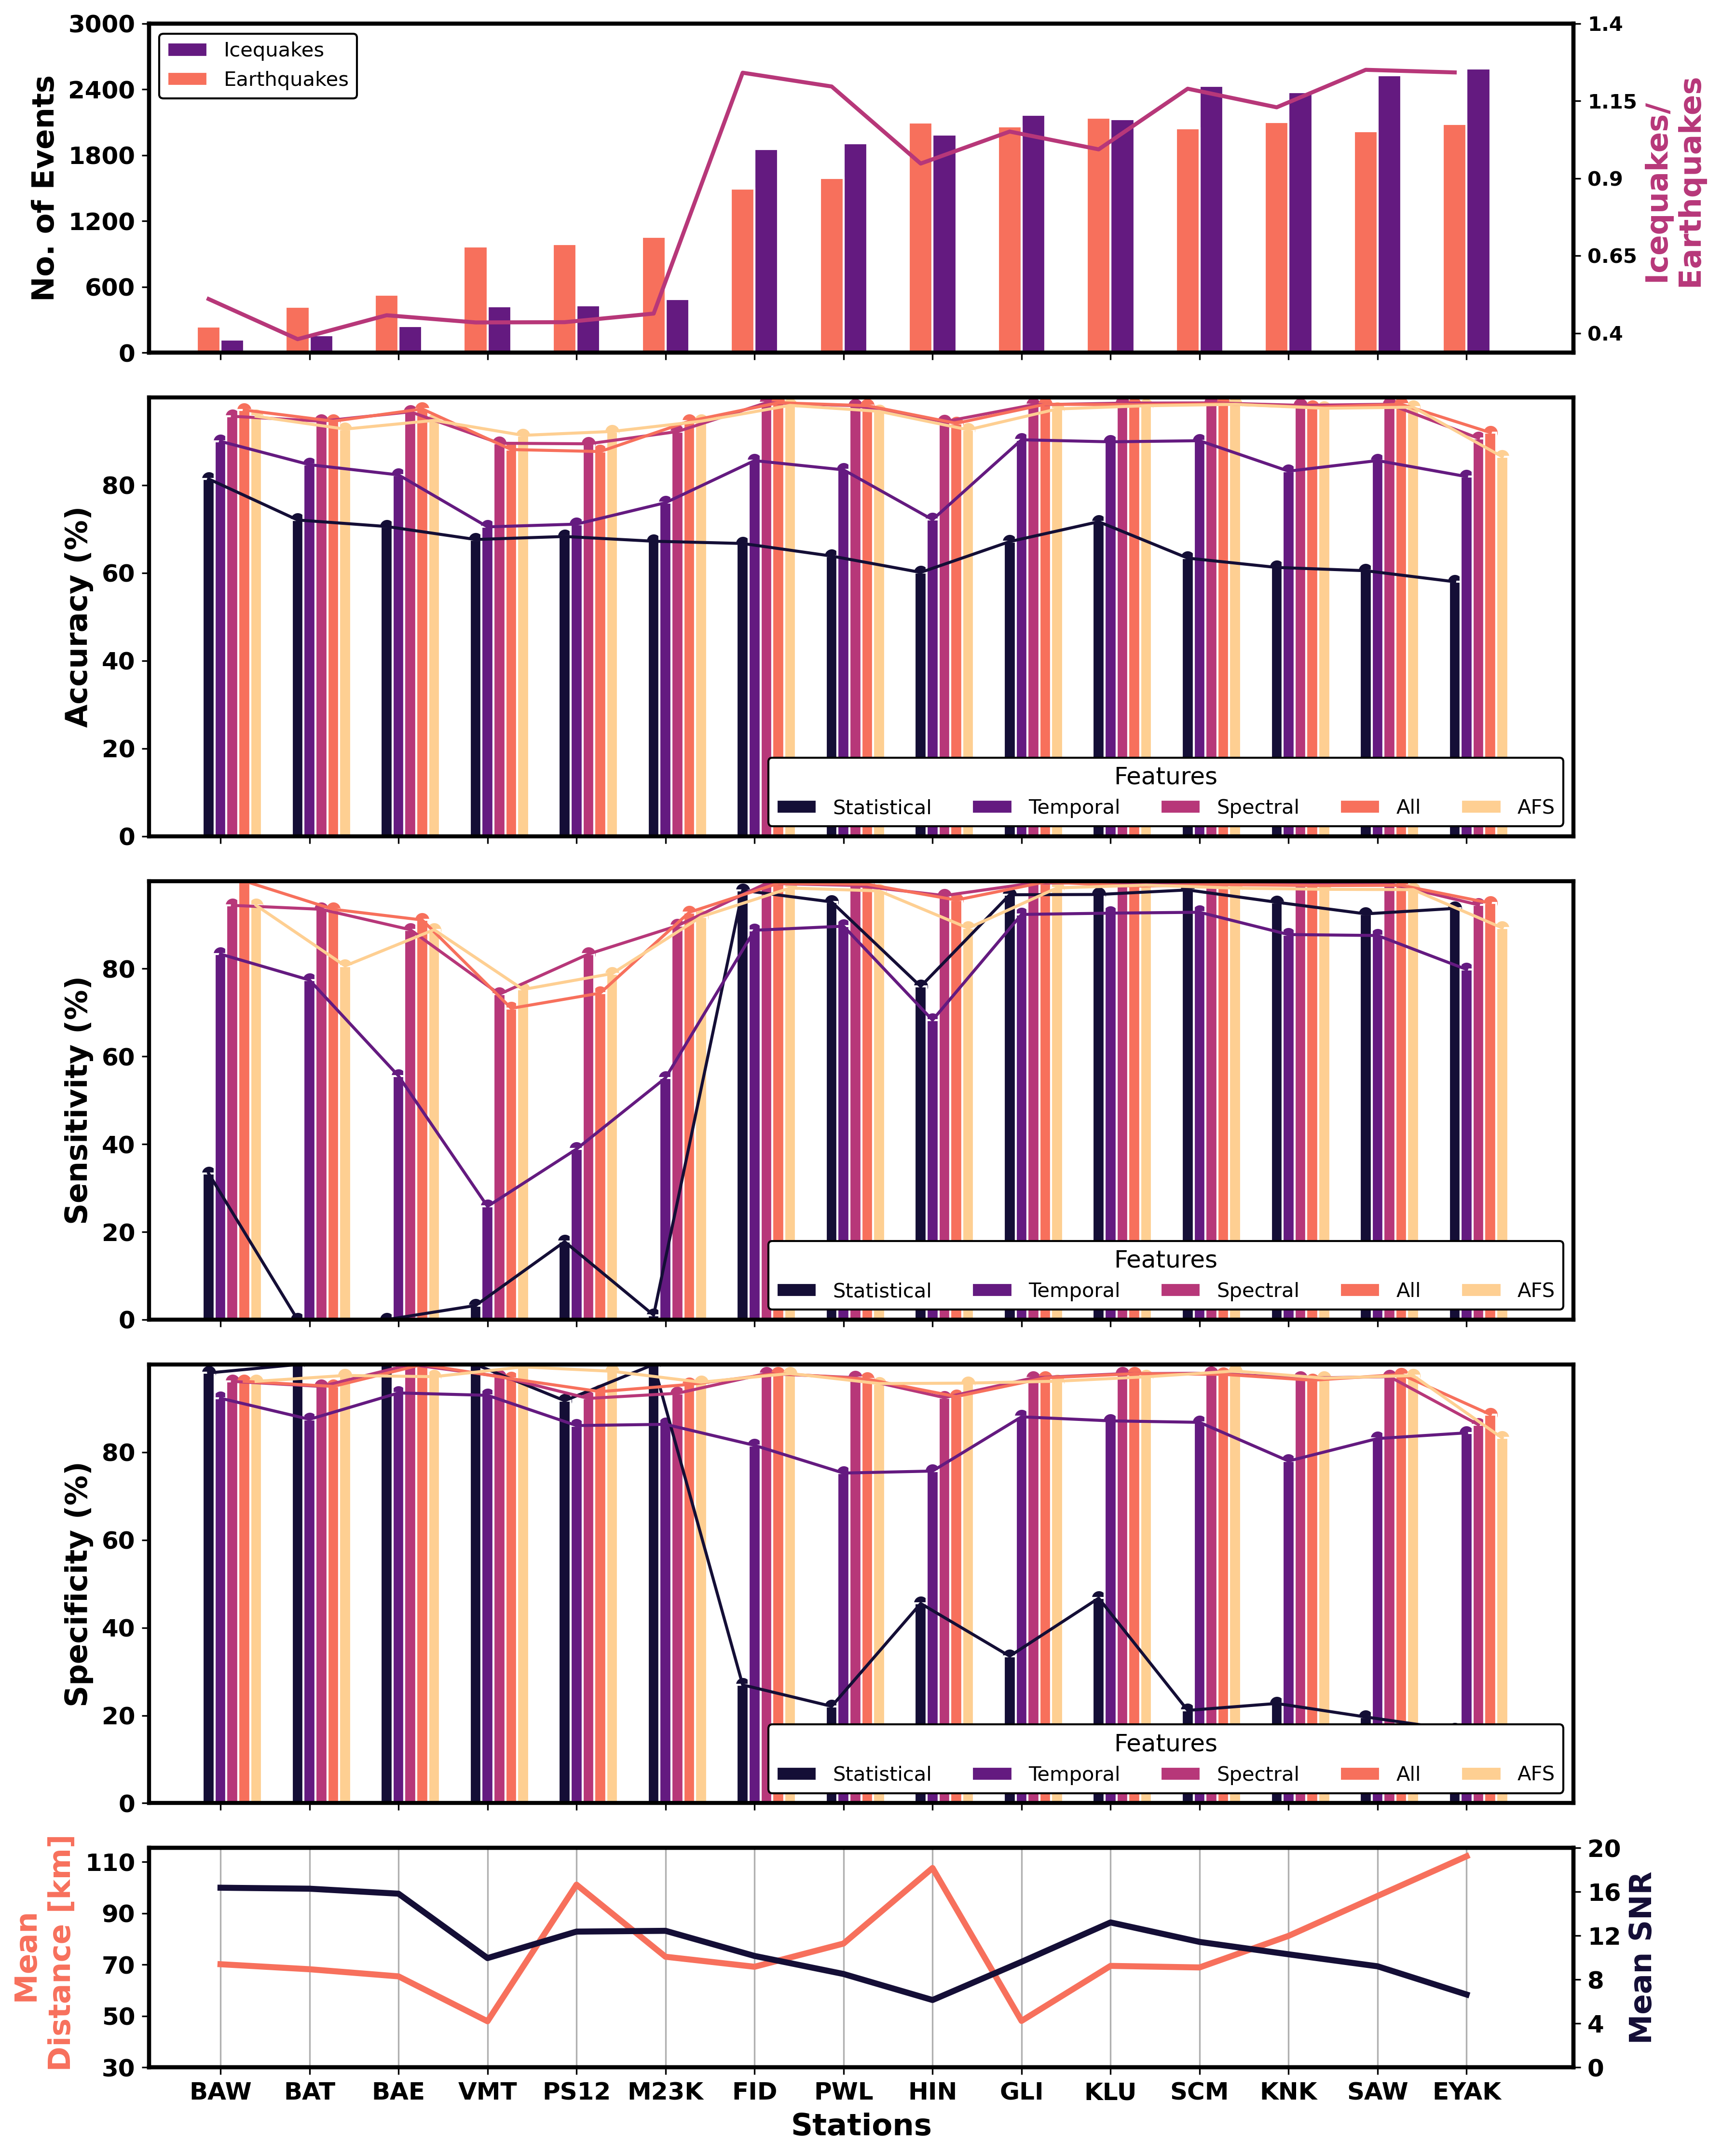

In [61]:
fig, (ax,ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, ncols=1, figsize=(12,15), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1.5,2,2,2,1]}, facecolor ='white', dpi = 300)




## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)
# set width of bar
barWidth = 0.2
# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]



ratio = np.array(no_of_icequakes)/np.array(no_of_earthquakes)

#################                
# Setting up the first axes
##############
ax.set_xlim(0,15)
ax_t = ax.twinx()
ax_t.plot(br1, ratio[order], color = c3, linewidth = 2)
ax_t.set_yticks(np.linspace(0.4,1.4,5))
ax_t.set_yticklabels([str(i) for i in np.linspace(0.4,1.4,5)],fontsize=10, fontweight='bold')
ax_t.set_ylabel('Icequakes/ \n Earthquakes', fontsize=15, fontweight='bold', color=c3)

ax.bar(br3, np.array(no_of_icequakes)[order], color =c2, width = 0.4,
     label ='Icequakes',edgecolor='w')
ax.bar(br1, np.array(no_of_earthquakes)[order], color =c4, width = 0.4,
     label ='Earthquakes',edgecolor='w')

#ax.bar(np.arange(15)+0.5, total_events[order], width=0.6)
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12, fontweight='bold')
ax.set_ylabel('No. of Events', fontsize=15, fontweight='bold')
ax.legend(loc='upper left',ncol=1, facecolor='white', framealpha=1, edgecolor='black', fontsize=10)


#########
# Setting up second axes
########


a1 = np.array(acc_stat)*100
a2 = np.array(acc_temp)*100
a3 = np.array(acc_spec)*100
a4 = np.array(acc_all)*100
a5 = np.array(acc_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax1.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax1.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax1.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax1.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax1.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax1.scatter(br1, a1[order], color=c1)
ax1.scatter(br2, a2[order], color=c2) 
ax1.scatter(br3, a3[order], color=c3) 
ax1.scatter(br4, a4[order], color=c4) 
ax1.scatter(br5, a5[order], color=c5) 

ax1.plot(br1, a1[order], color=c1)
ax1.plot(br2, a2[order], color=c2) 
ax1.plot(br3, a3[order], color=c3)
ax1.plot(br4, a4[order], color=c4)
ax1.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax1.set_title('Accuracy', fontweight ='bold', fontsize = 15)
ax1.set_ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
ax1.set_yticks(ticks = np.arange(0,100,20))
ax1.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax1.set_ylim(0,100)
ax1.set_xlim(-1,23)
ax1.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)




###############
# Setting up third axes
##############

a1 = np.array(sens_stat)*100
a2 = np.array(sens_temp)*100
a3 = np.array(sens_spec)*100
a4 = np.array(sens_all)*100
a5 = np.array(sens_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax2.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax2.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax2.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax2.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax2.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax2.scatter(br1, a1[order], color=c1)
ax2.scatter(br2, a2[order], color=c2) 
ax2.scatter(br3, a3[order], color=c3) 
ax2.scatter(br4, a4[order], color=c4) 
ax2.scatter(br5, a5[order], color=c5) 

ax2.plot(br1, a1[order], color=c1)
ax2.plot(br2, a2[order], color=c2) 
ax2.plot(br3, a3[order], color=c3)
ax2.plot(br4, a4[order], color=c4)
ax2.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax2.set_title('Sensitivity', fontweight ='bold', fontsize = 15)
ax2.set_ylabel('Sensitivity (%)', fontweight ='bold', fontsize = 15)
ax2.set_yticks(ticks = np.arange(0,100,20))
ax2.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax2.set_ylim(0,100)
ax2.set_xlim(-1,23)
ax2.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)



###############
# Setting up fourth axes
##############

a1 = np.array(speci_stat)*100
a2 = np.array(speci_temp)*100
a3 = np.array(speci_spec)*100
a4 = np.array(speci_all)*100
a5 = np.array(speci_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax3.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax3.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax3.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax3.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax3.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax3.scatter(br1, a1[order], color=c1)
ax3.scatter(br2, a2[order], color=c2) 
ax3.scatter(br3, a3[order], color=c3) 
ax3.scatter(br4, a4[order], color=c4) 
ax3.scatter(br5, a5[order], color=c5) 

ax3.plot(br1, a1[order], color=c1)
ax3.plot(br2, a2[order], color=c2) 
ax3.plot(br3, a3[order], color=c3)
ax3.plot(br4, a4[order], color=c4)
ax3.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax3.set_title('Specificity', fontweight ='bold', fontsize = 15)
ax3.set_ylabel('Specificity (%)', fontweight ='bold', fontsize = 15)
ax3.set_yticks(ticks = np.arange(0,100,20))
ax3.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax3.set_ylim(0,100)
ax3.set_xlim(-1,23)
ax3.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)



###############
# Setting up fifth axes
##############

ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_array)[order], linewidth = 3, color=c4, label = "Earthquakes")
#ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_iq)[order], linewidth = 3, color= c5, label = "Icequakes")
ax4.set_xticks(ticks = [1.5*r + barWidth for r in range(len(a1))])
ax4.set_xticklabels( labels = stations[order], fontsize=12, fontweight='bold')
ax4.set_yticks(ticks = np.arange(30,120,20))
ax4.set_yticklabels(labels = [str(i) for i in np.arange(30,120,20)], fontsize=12, fontweight='bold')
ax4.set_ylabel(' Mean \n Distance [km]', color = c4, fontsize=15, fontweight = 'bold')
#ax2.set_xlim(0,15)
#ax4.legend(loc='lower right',ncol=2,facecolor='white', framealpha=1, edgecolor='black', fontsize=10,  title ='Mean distance (km)', title_fontsize = 10)
ax4.set_xlabel('Stations', fontsize=15, fontweight = 'bold')
ax4.xaxis.grid(True)

ax5 = ax4.twinx()
ax5.plot([1.5*r + barWidth for r in range(len(a1))], np.array(snr_array)[order], linewidth = 3, color=c1)
ax5.set_yticks(np.linspace(0,20,6))
ax5.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12, fontweight='bold')
ax5.set_ylabel('Mean SNR', color=c1, fontsize=15, fontweight='bold')

fig.tight_layout()


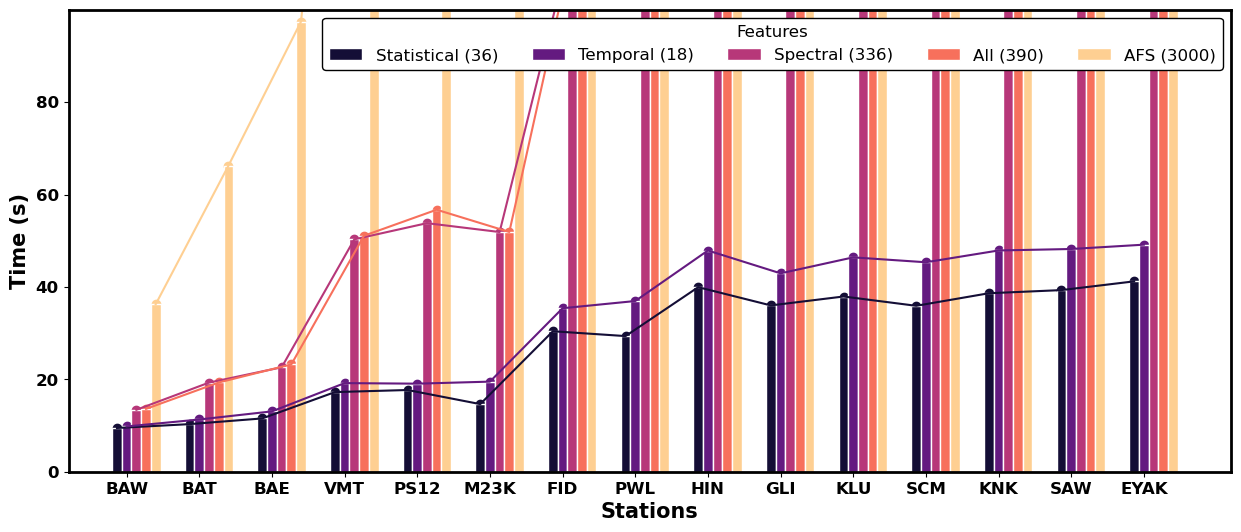

In [62]:
a1 = np.array(dur_stat)*100
a2 = np.array(dur_temp)*100
a3 = np.array(dur_spec)*100
a4 = np.array(dur_all)*100
a5 = np.array(dur_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
import numpy as np
import matplotlib.pyplot as plt


import matplotlib

cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, a1[order], color =c1, width = barWidth,
        label ='Statistical (36)',edgecolor='w')
plt.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal (18)',edgecolor='w')
plt.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral (336)',edgecolor='w')
plt.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All (390)',edgecolor='w')
plt.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS (3000)',edgecolor='w')


v = np.vstack((a1[order],a2[order]))
X = [br1, br2]
c= [c2,c5]
#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


plt.scatter(br1, a1[order], color=c1)
plt.scatter(br2, a2[order], color=c2) 
plt.scatter(br3, a3[order], color=c3) 
plt.scatter(br4, a4[order], color=c4) 
plt.scatter(br5, a5[order], color=c5) 

plt.plot(br1, a1[order], color=c1)
plt.plot(br2, a2[order], color=c2) 
plt.plot(br3, a3[order], color=c3)
plt.plot(br4, a4[order], color=c4)
plt.plot(br5, a5[order], color=c5)

# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.ylabel('Time (s)', fontweight ='bold', fontsize = 15)
plt.yticks(np.arange(0,100,20), fontweight = 'bold', fontsize=12)
plt.xticks([1.5*r + barWidth for r in range(len(a1))],stations[order], fontsize= 12, fontweight='bold')
plt.ylim(0,100)
plt.xlim(-1,23)
plt.legend(loc='upper right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, title ='Features', title_fontsize=12)
#plt.show()

#plt.savefig('Manuscript_Figures/Features_Performance_Comparison_averaged.eps')








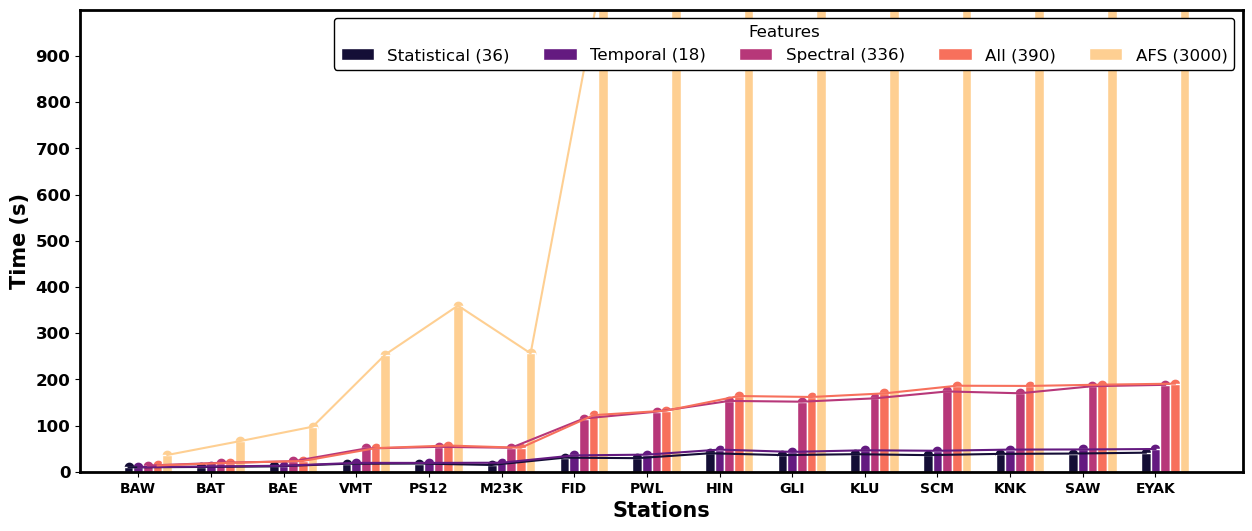

In [63]:
a1 = np.array(dur_stat)*100
a2 = np.array(dur_temp)*100
a3 = np.array(dur_spec)*100
a4 = np.array(dur_all)*100
a5 = np.array(dur_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
import numpy as np
import matplotlib.pyplot as plt


import matplotlib

cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, a1[order], color =c1, width = barWidth,
        label ='Statistical (36)',edgecolor='w')
plt.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal (18)',edgecolor='w')
plt.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral (336)',edgecolor='w')
plt.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All (390)',edgecolor='w')
plt.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS (3000)',edgecolor='w')


v = np.vstack((a1[order],a2[order]))
X = [br1, br2]
c= [c2,c5]
#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


plt.scatter(br1, a1[order], color=c1)
plt.scatter(br2, a2[order], color=c2) 
plt.scatter(br3, a3[order], color=c3) 
plt.scatter(br4, a4[order], color=c4) 
plt.scatter(br5, a5[order], color=c5) 

plt.plot(br1, a1[order], color=c1)
plt.plot(br2, a2[order], color=c2) 
plt.plot(br3, a3[order], color=c3)
plt.plot(br4, a4[order], color=c4)
plt.plot(br5, a5[order], color=c5)

# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)

plt.ylabel('Time (s)', fontweight ='bold', fontsize = 15)
plt.yticks(np.arange(0,1000,100), fontweight = 'bold', fontsize=12)
plt.xticks([1.5*r + barWidth for r in range(len(a1))],stations[order], fontweight='black')
plt.ylim(0,1000)
plt.xlim(-1,23)
plt.legend(loc='upper right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, title ='Features', title_fontsize=12)
#plt.show()

#plt.savefig('Manuscript_Figures/Features_Performance_Comparison_averaged.eps')








### Measuring Performance with balanced classes as input

In [66]:
## Computing the accuracy, sensitivity, specificity and duration across different feature types.
acc_spec = []
sens_spec = []
speci_spec = []
dur_spec = []


acc_temp = []
sens_temp = []
speci_temp = []
dur_temp = []

acc_stat = []
sens_stat = []
speci_stat = []
dur_stat = []

acc_all = []
sens_all = []
speci_all = []
dur_all = []

acc_afs = []
sens_afs = []
speci_afs = []
dur_afs = []

for i in tqdm(range(len(stations))):
    
    # Extract statistical features
    X1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+".txt")
    y1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test_balanced(X1, y1)
    acc_stat.append(o1)
    sens_stat.append(o2)
    speci_stat.append(o3)
    dur_stat.append(o4)
    
    
    # Extract temporal features
    X2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+".txt")
    y2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test_balanced(X2, y2)
    acc_temp.append(o1)
    sens_temp.append(o2)
    speci_temp.append(o3)
    dur_temp.append(o4)
    
    # Extract spectral features
    X3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+".txt")
    y3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test_balanced(X3, y3)
    acc_spec.append(o1)
    sens_spec.append(o2)
    speci_spec.append(o3)
    dur_spec.append(o4)
    
    
    ## Stacking all features
    X = np.loadtxt("tsfel_features/all/1min/"+stations[i]+".txt")
    #X = np.hstack([X1,X2,X3])
    y = np.loadtxt("tsfel_features/all/1min/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test_balanced(X, y)
    acc_all.append(o1)
    sens_all.append(o2)
    speci_all.append(o3)
    dur_all.append(o4)
    
    Xr = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
    yr = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test_balanced(Xr, yr)
    acc_afs.append(o1)
    sens_afs.append(o2)
    speci_afs.append(o3)
    dur_afs.append(o4)
    
    
    

  0%|          | 0/15 [00:00<?, ?it/s]

No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238
No of Icequakes:238
No of Earthquakes:525
Icequakes:238
Earthquakes:238


  7%|▋         | 1/15 [00:02<00:38,  2.77s/it]

No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155
No of Icequakes:155
No of Earthquakes:400
Icequakes:155
Earthquakes:155


 13%|█▎        | 2/15 [00:04<00:30,  2.32s/it]

No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116
No of Icequakes:116
No of Earthquakes:230
Icequakes:116
Earthquakes:116


 20%|██        | 3/15 [00:06<00:22,  1.90s/it]

No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083
No of Icequakes:2546
No of Earthquakes:2083
Icequakes:2083
Earthquakes:2083


 27%|██▋       | 4/15 [00:31<02:02, 11.18s/it]

No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484
No of Icequakes:1851
No of Earthquakes:1484
Icequakes:1484
Earthquakes:1484


 33%|███▎      | 5/15 [00:50<02:21, 14.14s/it]

No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047
No of Icequakes:2151
No of Earthquakes:2047
Icequakes:2047
Earthquakes:2047


 40%|████      | 6/15 [01:17<02:44, 18.33s/it]

No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980
No of Icequakes:1980
No of Earthquakes:2095
Icequakes:1980
Earthquakes:1980


 47%|████▋     | 7/15 [01:45<02:51, 21.38s/it]

No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121
No of Icequakes:2121
No of Earthquakes:2130
Icequakes:2121
Earthquakes:2121


 53%|█████▎    | 8/15 [02:12<02:43, 23.32s/it]

No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100
No of Icequakes:2365
No of Earthquakes:2100
Icequakes:2100
Earthquakes:2100


 60%|██████    | 9/15 [02:41<02:30, 25.05s/it]

No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471
No of Icequakes:471
No of Earthquakes:1006
Icequakes:471
Earthquakes:471


 67%|██████▋   | 10/15 [02:46<01:35, 19.00s/it]

No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430
No of Icequakes:430
No of Earthquakes:989
Icequakes:430
Earthquakes:430


 73%|███████▎  | 11/15 [02:52<00:59, 14.85s/it]

No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588
No of Icequakes:1896
No of Earthquakes:1588
Icequakes:1588
Earthquakes:1588


 80%|████████  | 12/15 [03:13<00:50, 16.89s/it]

No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020
No of Icequakes:2496
No of Earthquakes:2020
Icequakes:2020
Earthquakes:2020


 87%|████████▋ | 13/15 [03:39<00:39, 19.66s/it]

No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038
No of Icequakes:2425
No of Earthquakes:2038
Icequakes:2038
Earthquakes:2038


 93%|█████████▎| 14/15 [04:07<00:22, 22.00s/it]

No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420
No of Icequakes:420
No of Earthquakes:967
Icequakes:420
Earthquakes:420


100%|██████████| 15/15 [04:12<00:00, 16.83s/it]


In [68]:
bal_quakes = []

for i in range(len(stations)):
    bal_quakes.append(min(no_of_icequakes[i], no_of_earthquakes[i]))



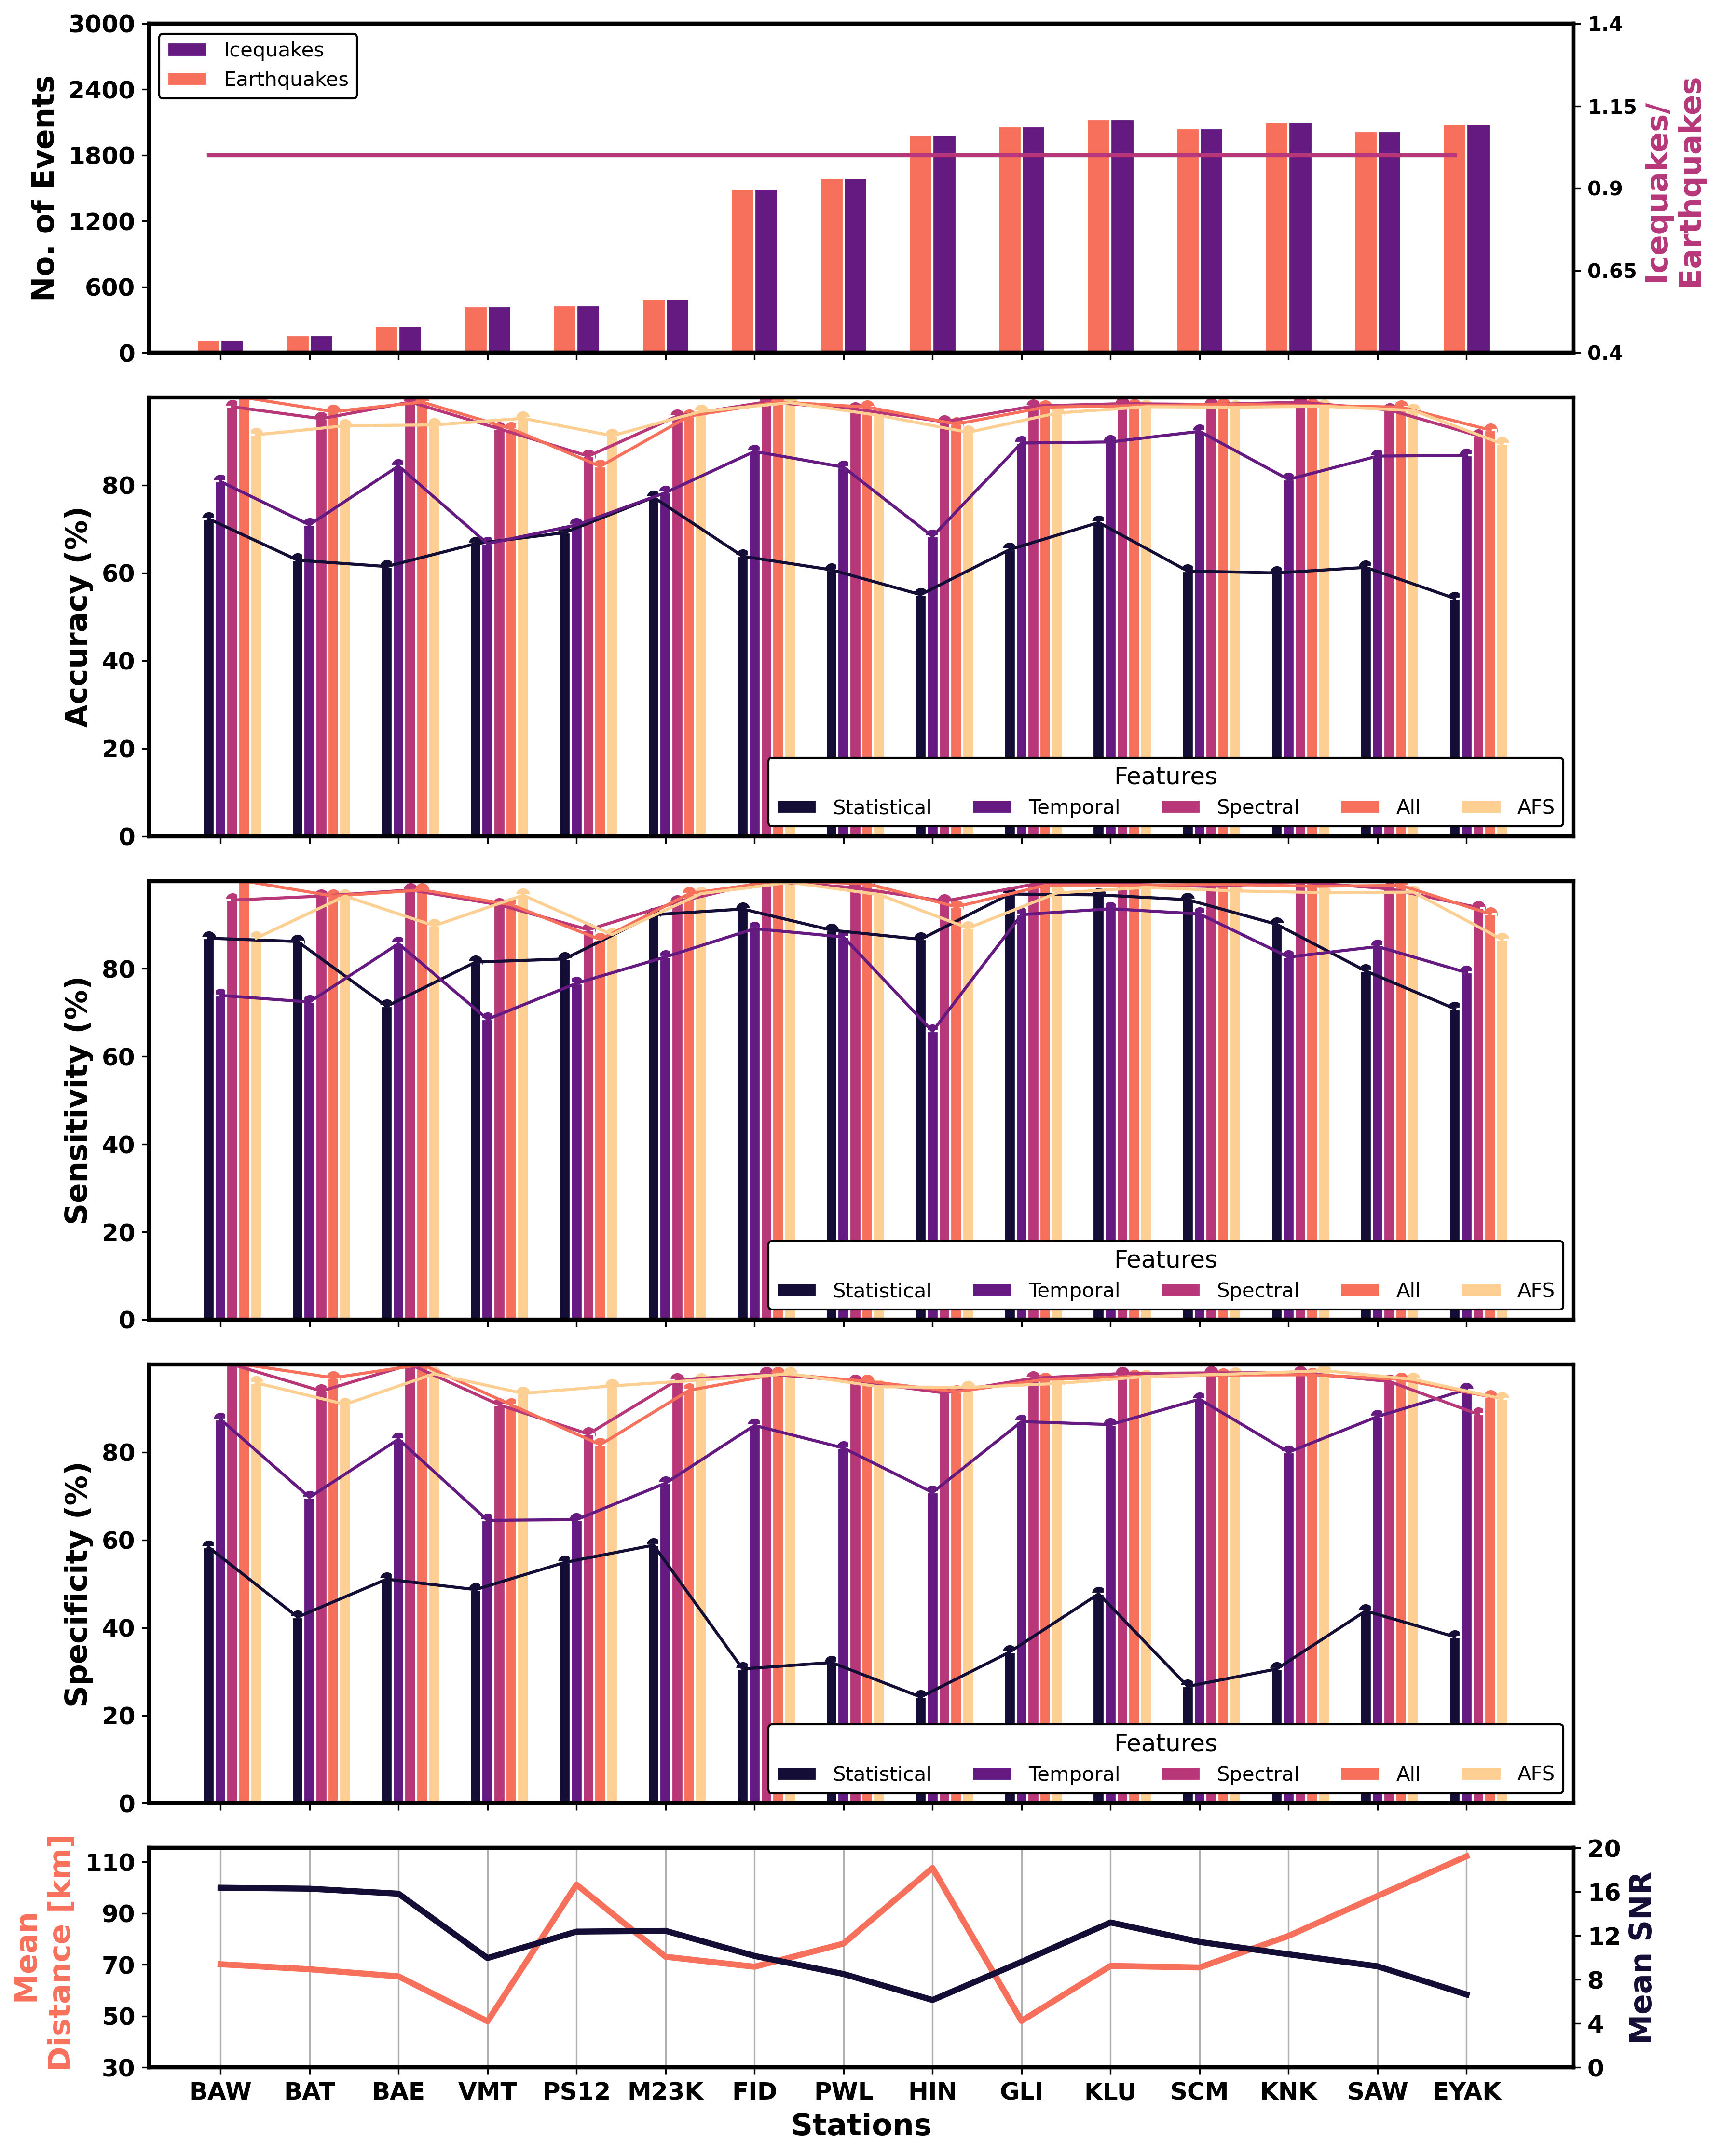

In [69]:
fig, (ax,ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, ncols=1, figsize=(12,15), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1.5,2,2,2,1]}, facecolor ='white', dpi = 300)




## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)
# set width of bar


a1 = np.array(acc_stat)*100
a2 = np.array(acc_temp)*100
a3 = np.array(acc_spec)*100
a4 = np.array(acc_all)*100
a5 = np.array(acc_afs)*100


barWidth = 0.2
# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]



ratio = np.array(bal_quakes)/np.array(bal_quakes)

#################                
# Setting up the first axes
##############
ax.set_xlim(0,15)
ax_t = ax.twinx()
ax_t.plot(br1, ratio[order], color = c3, linewidth = 2)
ax_t.set_yticks(np.linspace(0.4,1.4,5))
ax_t.set_yticklabels([str(i) for i in np.linspace(0.4,1.4,5)],fontsize=10, fontweight='bold')
ax_t.set_ylabel('Icequakes/ \n Earthquakes', fontsize=15, fontweight='bold', color=c3)

ax.bar(br3, np.array(bal_quakes)[order], color =c2, width = 0.4,
     label ='Icequakes',edgecolor='w')
ax.bar(br1, np.array(bal_quakes)[order], color =c4, width = 0.4,
     label ='Earthquakes',edgecolor='w')

#ax.bar(np.arange(15)+0.5, total_events[order], width=0.6)
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12, fontweight='bold')
ax.set_ylabel('No. of Events', fontsize=15, fontweight='bold')
ax.legend(loc='upper left',ncol=1, facecolor='white', framealpha=1, edgecolor='black', fontsize=10)


#########
# Setting up second axes
########





plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax1.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax1.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax1.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax1.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax1.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax1.scatter(br1, a1[order], color=c1)
ax1.scatter(br2, a2[order], color=c2) 
ax1.scatter(br3, a3[order], color=c3) 
ax1.scatter(br4, a4[order], color=c4) 
ax1.scatter(br5, a5[order], color=c5) 

ax1.plot(br1, a1[order], color=c1)
ax1.plot(br2, a2[order], color=c2) 
ax1.plot(br3, a3[order], color=c3)
ax1.plot(br4, a4[order], color=c4)
ax1.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax1.set_title('Accuracy', fontweight ='bold', fontsize = 15)
ax1.set_ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
ax1.set_yticks(ticks = np.arange(0,100,20))
ax1.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax1.set_ylim(0,100)
ax1.set_xlim(-1,23)
ax1.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)




###############
# Setting up third axes
##############

a1 = np.array(sens_stat)*100
a2 = np.array(sens_temp)*100
a3 = np.array(sens_spec)*100
a4 = np.array(sens_all)*100
a5 = np.array(sens_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax2.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax2.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax2.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax2.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax2.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax2.scatter(br1, a1[order], color=c1)
ax2.scatter(br2, a2[order], color=c2) 
ax2.scatter(br3, a3[order], color=c3) 
ax2.scatter(br4, a4[order], color=c4) 
ax2.scatter(br5, a5[order], color=c5) 

ax2.plot(br1, a1[order], color=c1)
ax2.plot(br2, a2[order], color=c2) 
ax2.plot(br3, a3[order], color=c3)
ax2.plot(br4, a4[order], color=c4)
ax2.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax2.set_title('Sensitivity', fontweight ='bold', fontsize = 15)
ax2.set_ylabel('Sensitivity (%)', fontweight ='bold', fontsize = 15)
ax2.set_yticks(ticks = np.arange(0,100,20))
ax2.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax2.set_ylim(0,100)
ax2.set_xlim(-1,23)
ax2.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)



###############
# Setting up fourth axes
##############

a1 = np.array(speci_stat)*100
a2 = np.array(speci_temp)*100
a3 = np.array(speci_spec)*100
a4 = np.array(speci_all)*100
a5 = np.array(speci_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax3.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax3.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax3.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax3.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax3.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax3.scatter(br1, a1[order], color=c1)
ax3.scatter(br2, a2[order], color=c2) 
ax3.scatter(br3, a3[order], color=c3) 
ax3.scatter(br4, a4[order], color=c4) 
ax3.scatter(br5, a5[order], color=c5) 

ax3.plot(br1, a1[order], color=c1)
ax3.plot(br2, a2[order], color=c2) 
ax3.plot(br3, a3[order], color=c3)
ax3.plot(br4, a4[order], color=c4)
ax3.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax3.set_title('Specificity', fontweight ='bold', fontsize = 15)
ax3.set_ylabel('Specificity (%)', fontweight ='bold', fontsize = 15)
ax3.set_yticks(ticks = np.arange(0,100,20))
ax3.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax3.set_ylim(0,100)
ax3.set_xlim(-1,23)
ax3.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)



###############
# Setting up fifth axes
##############

ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_array)[order], linewidth = 3, color=c4, label = "Earthquakes")
#ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_iq)[order], linewidth = 3, color= c5, label = "Icequakes")
ax4.set_xticks(ticks = [1.5*r + barWidth for r in range(len(a1))])
ax4.set_xticklabels( labels = stations[order], fontsize=12, fontweight='bold')
ax4.set_yticks(ticks = np.arange(30,120,20))
ax4.set_yticklabels(labels = [str(i) for i in np.arange(30,120,20)], fontsize=12, fontweight='bold')
ax4.set_ylabel(' Mean \n Distance [km]', color = c4, fontsize=15, fontweight = 'bold')
#ax2.set_xlim(0,15)
#ax4.legend(loc='lower right',ncol=2,facecolor='white', framealpha=1, edgecolor='black', fontsize=10,  title ='Mean distance (km)', title_fontsize = 10)
ax4.set_xlabel('Stations', fontsize=15, fontweight = 'bold')
ax4.xaxis.grid(True)

ax5 = ax4.twinx()
ax5.plot([1.5*r + barWidth for r in range(len(a1))], np.array(snr_array)[order], linewidth = 3, color=c1)
ax5.set_yticks(np.linspace(0,20,6))
ax5.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12, fontweight='bold')
ax5.set_ylabel('Mean SNR', color=c1, fontsize=15, fontweight='bold')

fig.tight_layout()
